In [1]:
# standard
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings 
warnings.simplefilter('ignore')
import gc

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow/keras
from tensorflow import keras as kr
from tqdm.keras import TqdmCallback

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load Data

In [2]:
# load data
file = '../input/fake-news/FakeNewsNet.csv'
wanted_cols = ['title','real']
df = pd.read_csv(file, usecols=wanted_cols)

# drop NULLs (if any) & reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# adding a new column [word count]
df['wcount'] = df['title'].apply(lambda x: len(x.split(' ')))

# view
print(f"Found {df.shape[0]} news...")

Found 23196 news...


# Basic EDA

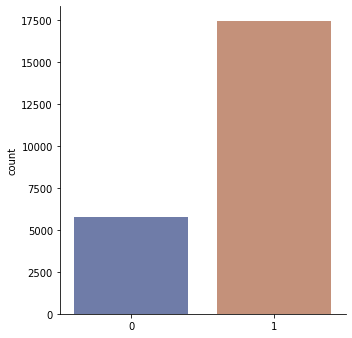

In [3]:
# basic EDA - count of fake & real
count = []
for i in df['real'].unique():
    count.append(df[df['real'] == i].count()[1])
    
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x=df['real'].unique(), y=count,alpha=.6,
    palette="dark")

#g.despine(left=True)
g.set_axis_labels("", "count")

# Feature Engineering

In [4]:
# feature engineering & training split
x = df['title'].values   # feature
y = df['real'].values    # target 

# train & validation split [80-20]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= np.random.randint(10))

# view
print(f"Training records: {x_train.shape[0]} | Testing records: {x_test.shape[0]}")

Training records: 18556 | Testing records: 4640


# Text Pre-Processing

In [5]:
# text pre-processing
tok = kr.preprocessing.text.Tokenizer(num_words=None,
                                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                      lower=True,
                                      split=' ',
                                      char_level=False,
                                      oov_token=None)

# fit 
tok.fit_on_texts(x_train)

# Text Tokenisation

In [6]:
# tokenized text data
tok_train = tok.texts_to_sequences(x_train)
tok_test = tok.texts_to_sequences(x_test)

# Pad Sequences

In [7]:
# padding the sequence
max_length = int(df.wcount.quantile(0.75))   # taking the 75th percentile of word count
padded_train = kr.preprocessing.sequence.pad_sequences(tok_train, maxlen=max_length, padding='post')
padded_test = kr.preprocessing.sequence.pad_sequences(tok_test, maxlen=max_length, padding='post')

# Simple RNN Model

In [8]:
# model params
vocab_size = len(tok.word_index) + 1
epoch = 10
unit = 32

# define model
model = kr.models.Sequential(name='FakeNewsCatcher')
model.add(kr.layers.Embedding(vocab_size, unit, input_length=max_length))
model.add(kr.layers.SimpleRNN(unit, return_sequences=False))
model.add(kr.layers.Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model.summary()

2022-11-14 01:14:18.261598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 01:14:18.262802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 01:14:18.594083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 01:14:18.595193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 01:14:18.596133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "FakeNewsCatcher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 32)            697824    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 699,937
Trainable params: 699,937
Non-trainable params: 0
_________________________________________________________________


In [9]:
# training params
es = kr.callbacks.EarlyStopping(monitor='val_loss', mode='min',verbose=0, patience=5)

# for re-runs
gc.collect()
kr.backend.clear_session()

# train model
hist = model.fit(x=padded_train,
                 y=y_train,
                 epochs=epoch,
                 shuffle=True,
                 validation_data=(padded_test,y_test),
                 verbose=0,
                 callbacks=[TqdmCallback(verbose=0),es])

0epoch [00:00, ?epoch/s]

2022-11-14 01:14:24.799879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
# accuracy
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of {acc} in {hist.epoch[-1]} epoch(s)")

Our model has achieved an accuracy of 96.71% in 6 epoch(s)


In [11]:
# predictions
pred = (model.predict(padded_test) > 0.5).astype('int32')
# classification report
print(classification_report(y_test, pred))
# accuracy score
acc_score = '{:.2%}'.format(accuracy_score(y_test, pred))
print(f"\nAccuracy Score: {acc_score}")

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1180
           1       0.86      0.87      0.87      3460

    accuracy                           0.80      4640
   macro avg       0.74      0.73      0.73      4640
weighted avg       0.80      0.80      0.80      4640


Accuracy Score: 79.91%


# Bi-directional (simple) RNN

In [12]:
model2 = kr.models.Sequential(name='FakeNewsCatcher2')
model2.add(kr.layers.Embedding(vocab_size, unit, input_length=max_length))
model2.add(kr.layers.Bidirectional(kr.layers.SimpleRNN(unit)))
model2.add(kr.layers.Dense(unit, activation='relu'))
model2.add(kr.layers.Dense(1, activation='sigmoid'))

# compile
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model2.summary()

Model: "FakeNewsCatcher2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 32)            697824    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                4160      
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 704,097
Trainable params: 704,097
Non-trainable params: 0
_________________________________________________________________


In [13]:
# for re-runs
gc.collect()
kr.backend.clear_session()

# train model
hist2 = model2.fit(x=padded_train,
                 y=y_train,
                 epochs=epoch,
                 shuffle=True,
                 validation_data=(padded_test,y_test),
                 verbose=0,
                 callbacks=[TqdmCallback(verbose=0),es])

0epoch [00:00, ?epoch/s]

In [14]:
# accuracy
acc2 = '{:.2%}'.format(hist2.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of {acc2} in {hist2.epoch[-1]} epoch(s)")

Our model has achieved an accuracy of 97.33% in 6 epoch(s)


In [15]:
# predictions
pred2 = (model2.predict(padded_test) > 0.5).astype('int32')
# classification report
print(classification_report(y_test, pred2))
# accuracy score
acc_score2 = '{:.2%}'.format(accuracy_score(y_test, pred2))
print(f"\nAccuracy Score: {acc_score2}")

              precision    recall  f1-score   support

           0       0.49      0.60      0.54      1180
           1       0.85      0.79      0.82      3460

    accuracy                           0.74      4640
   macro avg       0.67      0.69      0.68      4640
weighted avg       0.76      0.74      0.75      4640


Accuracy Score: 74.03%
